In [1]:
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
import re
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

In [5]:
test_data = pd.read_parquet("../data/second_departure_parquet_feats/sample_06.09.2022_all_features.parquet")

In [6]:
test_data.head()

,date,datetime,dev_id_1,id_1_last_lon,id_1_last_lat,dev_id_2,id_2_last_lon,id_2_last_lat,accelerometer_x_corr,accelerometer_x_diff_corr,...,bearing_corr,speed_corr,height_diff_corr,bearing_diff_corr,speed_diff_corr,speed_mean_abs_diff,speed_mean_diff,speed_std_diff,distance_mean,distance_std
0,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,0.000661,0.035777,...,0.205053,0.082422,0.014212,0.098073,0.029655,3.504287,-1.845214,9.843380,165.717646,141.099882
1,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.029039,0.067258,...,0.144063,0.052211,0.011149,0.152548,0.059629,2.732987,-1.196340,6.964679,133.042537,72.842306
2,2022-09-06,2022-09-06 07:38:07,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.002194,0.077567,...,0.306874,0.012220,0.001329,0.043845,0.007309,4.445489,0.413304,11.253297,88.975281,98.468099
3,2022-09-06,2022-09-06 07:48:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602780,55.893606,7F921169-FB12-471F-B244-62840E543DD7,37.603513,55.892299,0.024953,0.069213,...,0.046329,0.009875,0.011567,0.269572,0.014251,3.261829,-0.938763,8.793781,118.765372,16.460189
4,2022-09-06,2022-09-06 08:13:07,40808752-2CEE-454B-B6E6-95EC9615999D,37.603324,55.892073,8A8813E7-6012-4600-835D-1C286EADE837,37.602763,55.892618,0.203208,0.009416,...,0.204592,0.112317,0.010256,0.058706,0.119389,3.765288,0.098938,10.963710,38.229802,39.078068


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       1679 non-null   datetime64[ns]
 1   datetime                   1679 non-null   datetime64[ns]
 2   dev_id_1                   1679 non-null   object        
 3   id_1_last_lon              1679 non-null   float64       
 4   id_1_last_lat              1679 non-null   float64       
 5   dev_id_2                   1679 non-null   object        
 6   id_2_last_lon              1679 non-null   float64       
 7   id_2_last_lat              1679 non-null   float64       
 8   accelerometer_x_corr       1411 non-null   float64       
 9   accelerometer_x_diff_corr  1411 non-null   float64       
 10  accelerometer_y_corr       1492 non-null   float64       
 11  accelerometer_y_diff_corr  1492 non-null   float64       
 12  accele

In [8]:
test_data1 = pd.read_parquet("../data/second_departure_parquet/Данные за 06.09-12.09/Тест 5hz -2/Тест 5 Hz -2 06.09.2022.parquet")

In [9]:
test_data1.head()

,Наименование (device ID),Время отправки гео,bearing,Акселерометр,Гироскоп,Счетчик шагов,Скорость,"Точность, м",Долгота,Широта,Высота,Уровень заряда
0,40808752-2CEE-454B-B6E6-95EC9615999D,2022-09-06 08:14:50,293,"[\n 0.13168335,\n 5.323807,\n 7.882904\n]",[],3,0.223073,30,37.602669,55.892841,187.9,41
1,40808752-2CEE-454B-B6E6-95EC9615999D,2022-09-06 08:14:50,293,"[\n -1.4389191,\n 6.12825,\n 6.4655304\n]",[],3,0.223073,30,37.602669,55.892841,187.9,41
2,40808752-2CEE-454B-B6E6-95EC9615999D,2022-09-06 08:14:50,293,"[\n -1.2473755,\n 6.0516357,\n 6.6953735\n]",[],3,0.223073,30,37.602669,55.892841,187.9,41
3,40808752-2CEE-454B-B6E6-95EC9615999D,2022-09-06 08:14:51,293,"[\n -0.4046173,\n 5.3621063,\n 7.882904\n]",[],3,0.223073,30,37.602669,55.892841,187.9,41
4,40808752-2CEE-454B-B6E6-95EC9615999D,2022-09-06 08:14:51,293,"[\n -0.5195465,\n 5.4770355,\n 7.882904\n]",[],3,0.223073,30,37.602669,55.892841,187.9,41


In [10]:
test_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161215 entries, 0 to 161214
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Наименование (device ID)  161215 non-null  object        
 1   Время отправки гео        161215 non-null  datetime64[us]
 2   bearing                   161215 non-null  int64         
 3   Акселерометр              161215 non-null  object        
 4   Гироскоп                  161215 non-null  object        
 5   Счетчик шагов             161215 non-null  int64         
 6   Скорость                  161215 non-null  float64       
 7   Точность, м               161215 non-null  int64         
 8   Долгота                   161215 non-null  float64       
 9   Широта                    161215 non-null  float64       
 10  Высота                    161215 non-null  float64       
 11  Уровень заряда            161215 non-null  int64         
dtypes:

In [12]:
test_data2 = pd.read_parquet("../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09/Тест_5hz_-2/Тест_5_Hz_-2_06.09.2022.parquet")

In [13]:
test_data2.head()

,Наименование (device ID),Время отправки гео,bearing,Акселерометр,Гироскоп,Счетчик шагов,Скорость,"Точность, м",Долгота,Широта,Высота,Уровень заряда,timestamp_rownum,acc_x,acc_y,acc_z
0,40808752-2CEE-454B-B6E6-95EC9615999D,2022-09-06 08:14:50,293,"[0.13168335, 5.323807, 7.882904]",[],3,0.223073,30,37.602669,55.892841,187.9,41,1,0.131683,5.323807,7.882904
1,40808752-2CEE-454B-B6E6-95EC9615999D,2022-09-06 08:14:50,293,"[-1.4389191, 6.12825, 6.4655304]",[],3,0.223073,30,37.602669,55.892841,187.9,41,2,-1.438919,6.128250,6.465530
2,40808752-2CEE-454B-B6E6-95EC9615999D,2022-09-06 08:14:50,293,"[-1.2473755, 6.0516357, 6.6953735]",[],3,0.223073,30,37.602669,55.892841,187.9,41,3,-1.247375,6.051636,6.695373
3,40808752-2CEE-454B-B6E6-95EC9615999D,2022-09-06 08:14:51,293,"[-0.4046173, 5.3621063, 7.882904]",[],3,0.223073,30,37.602669,55.892841,187.9,41,1,-0.404617,5.362106,7.882904
4,40808752-2CEE-454B-B6E6-95EC9615999D,2022-09-06 08:14:51,293,"[-0.5195465, 5.4770355, 7.882904]",[],3,0.223073,30,37.602669,55.892841,187.9,41,2,-0.519547,5.477036,7.882904


In [14]:
test_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161215 entries, 0 to 161214
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Наименование (device ID)  161215 non-null  object        
 1   Время отправки гео        161215 non-null  datetime64[us]
 2   bearing                   161215 non-null  int64         
 3   Акселерометр              161215 non-null  object        
 4   Гироскоп                  161215 non-null  object        
 5   Счетчик шагов             161215 non-null  int64         
 6   Скорость                  161215 non-null  float64       
 7   Точность, м               161215 non-null  int64         
 8   Долгота                   161215 non-null  float64       
 9   Широта                    161215 non-null  float64       
 10  Высота                    161215 non-null  float64       
 11  Уровень заряда            161215 non-null  int64         
 12  ti

In [15]:
test_data3 = pd.read_parquet("../data/sample_11_02_all_features_high_radius.parquet")

In [16]:
test_data3.head()

,date,datetime,dev_id_1,id_1_last_lon,id_1_last_lat,dev_id_2,id_2_last_lon,id_2_last_lat,accelerometer_x_corr,accelerometer_x_diff_corr,...,bearing_corr,speed_corr,height_diff_corr,bearing_diff_corr,speed_diff_corr,speed_mean_abs_diff,speed_mean_diff,speed_std_diff,distance_mean,distance_std
0,2022-12-01,2022-12-01 10:48:18,D4909E26-0469-4045-B426-211006C38915,37.613123,55.894199,E9B9C64C-B66D-416D-BACD-3F0C9C2E1767,37.597539,55.891541,0.020848,0.013961,...,0.003843,0.040824,2.342438e-18,0.132480,0.033372,1.394553,0.712902,4.810753,2054.569542,19.910991
1,2022-12-01,2022-12-01 10:53:18,D4909E26-0469-4045-B426-211006C38915,37.613346,55.894110,E9B9C64C-B66D-416D-BACD-3F0C9C2E1767,37.597614,55.891387,0.024866,0.003584,...,0.045900,0.044286,3.524988e-02,0.002435,0.019051,2.427950,0.921701,6.956017,2037.886971,28.447167
2,2022-12-01,2022-12-01 10:58:18,D4909E26-0469-4045-B426-211006C38915,37.613084,55.893969,E9B9C64C-B66D-416D-BACD-3F0C9C2E1767,37.597684,55.891430,0.019898,0.030826,...,0.089580,0.078751,2.599786e-19,0.000066,0.108915,2.373555,1.524765,7.726640,2030.144925,26.966362
3,2022-12-01,2022-12-01 11:03:18,D4909E26-0469-4045-B426-211006C38915,37.613346,55.894205,E9B9C64C-B66D-416D-BACD-3F0C9C2E1767,37.597931,55.889485,0.030749,0.033406,...,0.154146,0.058034,3.337160e-03,0.037221,0.062985,2.975291,0.145192,7.078031,2010.692280,34.467854
4,2022-12-01,2022-12-01 11:08:18,D4909E26-0469-4045-B426-211006C38915,37.613375,55.894186,E9B9C64C-B66D-416D-BACD-3F0C9C2E1767,37.599243,55.889024,0.063623,0.093234,...,0.057259,0.059225,2.638958e-03,0.000309,0.074824,1.477277,-0.082662,3.710233,1936.012978,54.545285


In [17]:
test_data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483 entries, 0 to 482
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       483 non-null    datetime64[us]
 1   datetime                   483 non-null    datetime64[us]
 2   dev_id_1                   483 non-null    object        
 3   id_1_last_lon              483 non-null    float64       
 4   id_1_last_lat              483 non-null    float64       
 5   dev_id_2                   483 non-null    object        
 6   id_2_last_lon              483 non-null    float64       
 7   id_2_last_lat              483 non-null    float64       
 8   accelerometer_x_corr       435 non-null    float64       
 9   accelerometer_x_diff_corr  435 non-null    float64       
 10  accelerometer_y_corr       441 non-null    float64       
 11  accelerometer_y_diff_corr  441 non-null    float64       
 12  accelero

In [2]:
data = pd.read_parquet("../../data/02_interim/sample_06_12_all_features.parquet")

In [18]:
data = pd.read_parquet("../data/second_departure_parquet_feats/sample_06.09.2022_all_features.parquet")

In [19]:
list_of_files = list()
for (dirpath, dirnames, filenames) in os.walk("../data/second_departure_parquet_preprocessed/"):
    list_of_files += [os.path.join(dirpath, file) for file in filenames if ".parquet" in file]

In [20]:
list_of_files = [each for each in list_of_files if "Данные" in each]

In [56]:
list_of_files

['../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5hz_-_2_06.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5hz_-_2_07.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5hz_-_2_08.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5hz_-_2_09.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5_Hz_-2_06.09.2022.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5_Hz_-2_07.09.2022.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5_Hz_-2_08.09.2022.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5_Hz_-2_09.09.2022.pa

In [21]:
second_device = [each for each in list_of_files if "устройство" in each]

In [57]:
second_device

['../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5hz_-_2_06.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5hz_-_2_07.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5hz_-_2_08.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-2\\Тест_5hz_-_2_09.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-_5\\Тест_5hz_-_5_06.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-_5\\Тест_5hz_-_5_07.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_06.09-12.09\\Тест_5hz_-_5\\Тест_5hz_-_5_08.09.2022_2-е_устройство.parquet',
 '../data/second_departure_parquet_preprocessed/Данные_за_0

In [24]:
def get_date_from_filename(filename):
    filename_list = filename.replace('.parquet', '').split("_")
    for each in filename_list:
        found_date = re.search("[0-9][0-9](.)[0-9][0-9](.)20[0-9][0-9]$", each)
        if found_date is not None:
            return found_date.group()

In [64]:
def find_original_file(path, date):
    all_files = os.listdir(path)
    all_files = [each for each in all_files if date in each]
    all_files = [each for each in all_files if "устройство" not in each]
    all_files.reverse()
    return all_files

In [65]:
import os


files = []
for path in second_device:
    folder = path.rsplit("\\", 1)[0]  # тут мб поменяете на обратный слеш \ для винды
    date = get_date_from_filename(path)
    original_filepath = find_original_file(folder, date)
    if len(original_filepath) < 1:
        original_filepath = np.nan
    else:
        original_filepath = os.path.join(folder, original_filepath[0])
    files.append((path, original_filepath))

In [66]:
targets_df = []
for second_filepath, initial_filepath in files:
    if len(initial_filepath) != 0:
        second_df = pd.read_parquet(second_filepath)
        initial_df = pd.read_parquet(initial_filepath)
        date = initial_df["Время отправки гео"].dt.to_period("D").dt.to_timestamp()[0]
        second_name = second_df["Наименование (device ID)"][0]
        initial_name = initial_df["Наименование (device ID)"][0]
        tmp_df = pd.DataFrame([[date, second_name, initial_name]], columns=["date", "sec_name", "init_name"])
        targets_df.append(tmp_df)

In [67]:
targets_df = pd.concat(targets_df, ignore_index=True)

In [68]:
targets_df

,date,sec_name,init_name
0,2022-09-06,8A8813E7-6012-4600-835D-1C286EADE837,40808752-2CEE-454B-B6E6-95EC9615999D
1,2022-09-07,8A8813E7-6012-4600-835D-1C286EADE837,40808752-2CEE-454B-B6E6-95EC9615999D
2,2022-09-08,8A8813E7-6012-4600-835D-1C286EADE837,40808752-2CEE-454B-B6E6-95EC9615999D
3,2022-09-09,8A8813E7-6012-4600-835D-1C286EADE837,40808752-2CEE-454B-B6E6-95EC9615999D
4,2022-09-06,B94A4D90-F127-487B-9373-5FEE1A34A04F,38702660-F4AA-472F-8FAB-B3B47B5889AC
5,2022-09-07,B94A4D90-F127-487B-9373-5FEE1A34A04F,38702660-F4AA-472F-8FAB-B3B47B5889AC
6,2022-09-08,B94A4D90-F127-487B-9373-5FEE1A34A04F,38702660-F4AA-472F-8FAB-B3B47B5889AC
7,2022-09-09,B94A4D90-F127-487B-9373-5FEE1A34A04F,38702660-F4AA-472F-8FAB-B3B47B5889AC
8,2022-09-12,B94A4D90-F127-487B-9373-5FEE1A34A04F,38702660-F4AA-472F-8FAB-B3B47B5889AC
9,2022-09-06,294A06F3-F7FE-4AAC-8099-049733BA1315,0699B415-A73E-4CFA-B910-079AA0408B1B


In [52]:
list_of_files_test = list()
list_of_feats_test = list()
for (dirpath, dirnames, filenames) in os.walk("../data/second_departure_parquet_feats"):
    list_of_files_test += [os.path.join(dirpath, file) for file in filenames if ".parquet" in file]
for filename in list_of_files_test:
    df = pd.read_parquet(filename)
    list_of_feats_test += [df]
data = pd.concat(list_of_feats_test, ignore_index=True)

In [69]:
data_final = data.copy(deep=True)
for _, row in targets_df.iterrows():
    date_condition = data["date"] == row["date"]
    comparison_condition_1 = (data["dev_id_1"] == row["sec_name"]) & (data["dev_id_2"] == row["init_name"])
    comparison_condition_2 = (data["dev_id_2"] == row["sec_name"]) & (data["dev_id_1"] == row["init_name"])
    comparison_condition = comparison_condition_1 | comparison_condition_2
    condition = date_condition & comparison_condition
    data_final.loc[condition, "target"] = 1

In [70]:
data_final

,date,datetime,dev_id_1,id_1_last_lon,id_1_last_lat,dev_id_2,id_2_last_lon,id_2_last_lat,accelerometer_x_corr,accelerometer_x_diff_corr,...,speed_corr,height_diff_corr,bearing_diff_corr,speed_diff_corr,speed_mean_abs_diff,speed_mean_diff,speed_std_diff,distance_mean,distance_std,target
0,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,0.000661,0.035777,...,0.082422,1.421230e-02,0.098073,0.029655,3.504287,-1.845214,9.843380,165.717646,141.099882,NaN
1,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.029039,0.067258,...,0.052211,1.114944e-02,0.152548,0.059629,2.732987,-1.196340,6.964679,133.042537,72.842306,NaN
2,2022-09-06,2022-09-06 07:38:07,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.002194,0.077567,...,0.012220,1.329316e-03,0.043845,0.007309,4.445489,0.413304,11.253297,88.975281,98.468099,NaN
3,2022-09-06,2022-09-06 07:48:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602780,55.893606,7F921169-FB12-471F-B244-62840E543DD7,37.603513,55.892299,0.024953,0.069213,...,0.009875,1.156702e-02,0.269572,0.014251,3.261829,-0.938763,8.793781,118.765372,16.460189,NaN
4,2022-09-06,2022-09-06 08:13:07,40808752-2CEE-454B-B6E6-95EC9615999D,37.603324,55.892073,8A8813E7-6012-4600-835D-1C286EADE837,37.602763,55.892618,0.203208,0.009416,...,0.112317,1.025583e-02,0.058706,0.119389,3.765288,0.098938,10.963710,38.229802,39.078068,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6547,2022-09-12,2022-09-12 17:21:39,2D7135B3-1208-45BA-9B5A-0FC27C13B9B0,37.611783,55.892302,329C29F6-A464-4174-867E-50D7D163206C,37.610464,55.891030,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6548,2022-09-12,2022-09-12 17:21:39,0699B415-A73E-4CFA-B910-079AA0408B1B,37.611192,55.887478,40808752-2CEE-454B-B6E6-95EC9615999D,37.610962,55.887849,0.793525,0.601976,...,0.665669,NaN,NaN,0.619808,3.918556,2.154666,7.304032,98.934811,30.686367,NaN
6549,2022-09-12,2022-09-12 17:26:39,329C29F6-A464-4174-867E-50D7D163206C,37.610725,55.890972,55464DF0-C385-4349-801B-C8E1CB861CB5,37.610891,55.890427,0.025361,0.161036,...,0.070157,1.767547e-18,0.000059,0.050241,3.430670,-1.592060,9.831637,65.952005,7.381049,NaN
6550,2022-09-12,2022-09-12 17:26:39,0699B415-A73E-4CFA-B910-079AA0408B1B,37.611192,55.887478,40808752-2CEE-454B-B6E6-95EC9615999D,37.611027,55.887835,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data_final

,date,datetime,dev_id_1,id_1_last_lon,id_1_last_lat,dev_id_2,id_2_last_lon,id_2_last_lat,accelerometer_x_corr,accelerometer_x_diff_corr,...,speed_corr,height_diff_corr,bearing_diff_corr,speed_diff_corr,speed_mean_abs_diff,speed_mean_diff,speed_std_diff,distance_mean,distance_std,target
0,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,0.000661,0.035777,...,0.082422,1.421230e-02,0.098073,0.029655,3.504287,-1.845214,9.843380,165.717646,141.099882,NaN
1,2022-09-06,2022-09-06 07:38:07,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.002194,0.077567,...,0.012220,1.329316e-03,0.043845,0.007309,4.445489,0.413304,11.253297,88.975281,98.468099,NaN
2,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.029039,0.067258,...,0.052211,1.114944e-02,0.152548,0.059629,2.732987,-1.196340,6.964679,133.042537,72.842306,NaN
3,2022-09-06,2022-09-06 07:48:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602780,55.893606,7F921169-FB12-471F-B244-62840E543DD7,37.603513,55.892299,0.024953,0.069213,...,0.009875,1.156702e-02,0.269572,0.014251,3.261829,-0.938763,8.793781,118.765372,16.460189,NaN
4,2022-09-06,2022-09-06 08:13:07,40808752-2CEE-454B-B6E6-95EC9615999D,37.603324,55.892073,AE6C3F14-5263-4BF1-AD06-3A8CE0A27AAB,37.603368,55.892132,0.157693,0.012551,...,0.023942,5.139841e-03,0.754217,0.042451,4.843979,1.013350,12.424083,17.029361,15.709145,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6547,2022-09-12,2022-09-12 17:21:39,2D7135B3-1208-45BA-9B5A-0FC27C13B9B0,37.611783,55.892302,329C29F6-A464-4174-867E-50D7D163206C,37.610464,55.891030,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6548,2022-09-12,2022-09-12 17:21:39,0699B415-A73E-4CFA-B910-079AA0408B1B,37.611192,55.887478,40808752-2CEE-454B-B6E6-95EC9615999D,37.610962,55.887849,0.793525,0.601976,...,0.665669,NaN,NaN,0.619808,3.918556,2.154666,7.304032,98.934811,30.686367,NaN
6549,2022-09-12,2022-09-12 17:26:39,329C29F6-A464-4174-867E-50D7D163206C,37.610725,55.890972,55464DF0-C385-4349-801B-C8E1CB861CB5,37.610891,55.890427,0.025361,0.161036,...,0.070157,1.767547e-18,0.000059,0.050241,3.430670,-1.592060,9.831637,65.952005,7.381049,NaN
6550,2022-09-12,2022-09-12 17:26:39,0699B415-A73E-4CFA-B910-079AA0408B1B,37.611192,55.887478,40808752-2CEE-454B-B6E6-95EC9615999D,37.611027,55.887835,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 0 to 1678
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       1679 non-null   datetime64[ns]
 1   datetime                   1679 non-null   datetime64[ns]
 2   dev_id_1                   1679 non-null   object        
 3   id_1_last_lon              1679 non-null   float64       
 4   id_1_last_lat              1679 non-null   float64       
 5   dev_id_2                   1679 non-null   object        
 6   id_2_last_lon              1679 non-null   float64       
 7   id_2_last_lat              1679 non-null   float64       
 8   accelerometer_x_corr       1411 non-null   float64       
 9   accelerometer_x_diff_corr  1411 non-null   float64       
 10  accelerometer_y_corr       1492 non-null   float64       
 11  accelerometer_y_diff_corr  1492 non-null   float64       
 12  accele

In [46]:
list_of_files_test = list()
list_of_feats_test = list()
for (dirpath, dirnames, filenames) in os.walk("../data/second_departure_parquet_feats"):
    list_of_files_test += [os.path.join(dirpath, file) for file in filenames if ".parquet" in file]
for filename in list_of_files_test:
    df = pd.read_parquet(filename)
    list_of_feats_test += [df]

In [49]:
test_df = pd.concat(list_of_feats_test, ignore_index=True)

In [51]:
test_df

,date,datetime,dev_id_1,id_1_last_lon,id_1_last_lat,dev_id_2,id_2_last_lon,id_2_last_lat,accelerometer_x_corr,accelerometer_x_diff_corr,...,bearing_corr,speed_corr,height_diff_corr,bearing_diff_corr,speed_diff_corr,speed_mean_abs_diff,speed_mean_diff,speed_std_diff,distance_mean,distance_std
0,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,0.000661,0.035777,...,0.205053,0.082422,1.421230e-02,0.098073,0.029655,3.504287,-1.845214,9.843380,165.717646,141.099882
1,2022-09-06,2022-09-06 07:38:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602788,55.893562,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.029039,0.067258,...,0.144063,0.052211,1.114944e-02,0.152548,0.059629,2.732987,-1.196340,6.964679,133.042537,72.842306
2,2022-09-06,2022-09-06 07:38:07,3744EED3-A474-458B-AA4F-5357B8EE7FBF,37.606185,55.894089,393B6105-4D72-4E11-BEA1-394CD0AFC499,37.604149,55.895599,0.002194,0.077567,...,0.306874,0.012220,1.329316e-03,0.043845,0.007309,4.445489,0.413304,11.253297,88.975281,98.468099
3,2022-09-06,2022-09-06 07:48:07,1CB8D3E9-04BE-465D-B334-0E1F7F026A98,37.602780,55.893606,7F921169-FB12-471F-B244-62840E543DD7,37.603513,55.892299,0.024953,0.069213,...,0.046329,0.009875,1.156702e-02,0.269572,0.014251,3.261829,-0.938763,8.793781,118.765372,16.460189
4,2022-09-06,2022-09-06 08:13:07,40808752-2CEE-454B-B6E6-95EC9615999D,37.603324,55.892073,8A8813E7-6012-4600-835D-1C286EADE837,37.602763,55.892618,0.203208,0.009416,...,0.204592,0.112317,1.025583e-02,0.058706,0.119389,3.765288,0.098938,10.963710,38.229802,39.078068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6547,2022-09-12,2022-09-12 17:21:39,2D7135B3-1208-45BA-9B5A-0FC27C13B9B0,37.611783,55.892302,329C29F6-A464-4174-867E-50D7D163206C,37.610464,55.891030,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6548,2022-09-12,2022-09-12 17:21:39,0699B415-A73E-4CFA-B910-079AA0408B1B,37.611192,55.887478,40808752-2CEE-454B-B6E6-95EC9615999D,37.610962,55.887849,0.793525,0.601976,...,NaN,0.665669,NaN,NaN,0.619808,3.918556,2.154666,7.304032,98.934811,30.686367
6549,2022-09-12,2022-09-12 17:26:39,329C29F6-A464-4174-867E-50D7D163206C,37.610725,55.890972,55464DF0-C385-4349-801B-C8E1CB861CB5,37.610891,55.890427,0.025361,0.161036,...,0.246894,0.070157,1.767547e-18,0.000059,0.050241,3.430670,-1.592060,9.831637,65.952005,7.381049
6550,2022-09-12,2022-09-12 17:26:39,0699B415-A73E-4CFA-B910-079AA0408B1B,37.611192,55.887478,40808752-2CEE-454B-B6E6-95EC9615999D,37.611027,55.887835,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [72]:
data_final.reset_index(drop=True, inplace=True)

In [73]:
data_final["target"] = data_final["target"].fillna(0)

In [74]:
data_final["target"].value_counts()

target
0.0    5372
1.0    1180
Name: count, dtype: int64

In [75]:
data_final.reset_index(drop=True, inplace=True)
X = data_final.iloc[:, 8:-1]
# X = X.dropna(how="any")
X = X.fillna(-999)
y = data_final.loc[X.index, "target"]

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [77]:
features = X_train.columns.to_list()

In [78]:
features

['accelerometer_x_corr',
 'accelerometer_x_diff_corr',
 'accelerometer_y_corr',
 'accelerometer_y_diff_corr',
 'accelerometer_z_corr',
 'accelerometer_z_diff_corr',
 'x_metres_corr',
 'x_diff_metres_corr',
 'y_metres_corr',
 'y_diff_metres_corr',
 'height_corr',
 'bearing_corr',
 'speed_corr',
 'height_diff_corr',
 'bearing_diff_corr',
 'speed_diff_corr',
 'speed_mean_abs_diff',
 'speed_mean_diff',
 'speed_std_diff',
 'distance_mean',
 'distance_std']

In [22]:
import yaml

In [26]:
with open("features.yaml", "w") as fin:
    yaml.safe_dump(features, fin)

In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [80]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

In [95]:
gb = GradientBoostingClassifier(n_estimators=500)
gb.fit(X_train, y_train)

GradientBoostingClassifier(n_estimators=500)

In [97]:
ab = AdaBoostClassifier(n_estimators=500)
ab.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=500)

In [99]:
bagging = BaggingClassifier(n_estimators=500)
bagging.fit(X_train, y_train)

BaggingClassifier(n_estimators=500)

In [101]:
et = ExtraTreesClassifier(n_estimators=500)
et.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=500)

In [104]:
hist = HistGradientBoostingClassifier()
hist.fit(X_train, y_train)

HistGradientBoostingClassifier()

In [81]:
from sklearn.metrics import roc_auc_score

In [82]:
y_test_pred = rf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_test_pred)

0.9356379501004932

In [96]:
y_test_pred_gb = gb.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_test_pred_gb)

0.9293157584612031

In [98]:
y_test_pred_ab = ab.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_test_pred_ab)

0.9251144169377425

In [100]:
y_test_pred_bagging = bagging.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_test_pred_bagging)

0.9299433363736893

In [102]:
y_test_pred_et = et.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_test_pred_et)

0.9201402061522814

In [105]:
y_test_pred_hist = hist.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_test_pred_hist)

0.9422749396637312

In [83]:
from sklearn.metrics import precision_recall_curve

In [84]:
precision, recall, threshes = precision_recall_curve(y_test, y_test_pred)

In [85]:
import matplotlib.pyplot as plt

In [88]:
threshes[165]

0.394

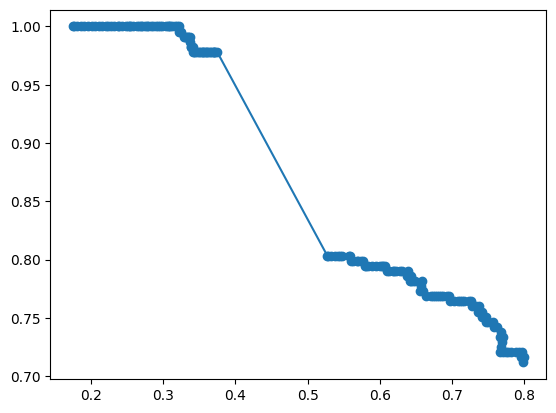

In [89]:
n = 165
plt.plot(precision[:n], recall[:n], marker='o')

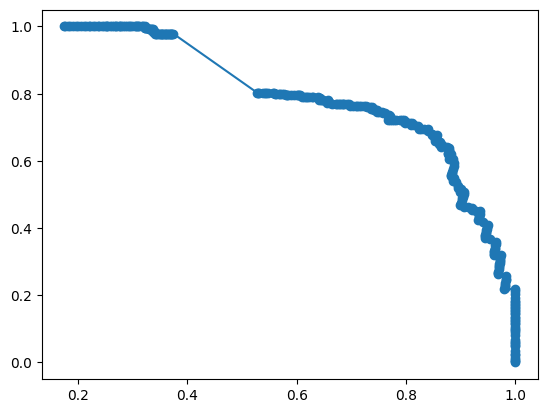

In [90]:
plt.plot(precision, recall, marker='o')

In [91]:
from sklearn.metrics import classification_report

In [92]:
y_thresh = (y_test_pred > 0.5).astype(int)
print(classification_report(y_test, y_thresh))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95      1082
         1.0       0.89      0.59      0.71       229

    accuracy                           0.92      1311
   macro avg       0.90      0.79      0.83      1311
weighted avg       0.91      0.92      0.91      1311



In [93]:
y_thresh = (y_test_pred >= 0.416).astype(int)
print(classification_report(y_test, y_thresh))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95      1082
         1.0       0.82      0.70      0.76       229

    accuracy                           0.92      1311
   macro avg       0.88      0.84      0.86      1311
weighted avg       0.92      0.92      0.92      1311



In [98]:
best_thresh = 0.416
sample_data = X_train.head(100) # fill na with "-999"
sample_data.to_csv("./random_forest_sample_data_thresh_0416.csv")

import pickle

with open("./random_forest_model.pkl", 'wb') as fin:
    pickle.dump(rf, fin)

In [100]:
X_train_columns = X_train.columns

In [103]:
rf.predict_proba(data_final[X_train_columns].fillna(-999))[:, 1]

array([0.01      , 0.034     , 0.        , ..., 0.012     , 0.15047577,
       0.004     ])

In [104]:
data_final["predicted_proba"] = rf.predict_proba(data_final[X_train_columns].fillna(-999))[:, 1]

In [105]:
data_final["thresh"] = 0.416

In [115]:
data_final["label"] = (data_final["predicted_proba"] > data_final["thresh"]).astype(int)

In [117]:
relevant_columns = ["datetime", "dev_id_1", "id_1_last_lon", "id_1_last_lat", 
                    "dev_id_2", "id_2_last_lon", "id_2_last_lat", 
                    "target", "predicted_proba", "thresh", "label"]

In [119]:
data_final[relevant_columns].to_csv("../../data/04_analytical_report/02_deviation_detection_report.csv", index=False)

In [30]:
y_test_pred = rf.predict(X_test)

In [31]:
from sklearn.metrics import classification_report

In [35]:
from sklearn.metrics import precision_recall_fscore_support

In [47]:
y_test_pred_thresh = (y_test_pred > 0.01).astype(int)
print(classification_report(y_test, y_test_pred_thresh))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      1081
         1.0       0.86      0.57      0.69       230

    accuracy                           0.91      1311
   macro avg       0.89      0.78      0.82      1311
weighted avg       0.91      0.91      0.90      1311



In [32]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.98      0.95      1081
         1.0       0.86      0.57      0.69       230

    accuracy                           0.91      1311
   macro avg       0.89      0.78      0.82      1311
weighted avg       0.91      0.91      0.90      1311



In [33]:
print(classification_report(y_train, rf.predict(X_train)))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      4291
         1.0       1.00      0.84      0.91       950

    accuracy                           0.97      5241
   macro avg       0.98      0.92      0.95      5241
weighted avg       0.97      0.97      0.97      5241

